In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [4]:
!unzip '/content/caltech-transportation (2).zip'

Archive:  /content/caltech-transportation (2).zip
   creating: caltech-transportation_test/
   creating: caltech-transportation_test/airplanes/
  inflating: caltech-transportation_test/airplanes/image_0003.jpg  
  inflating: caltech-transportation_test/airplanes/image_0008.jpg  
  inflating: caltech-transportation_test/airplanes/image_0011.jpg  
  inflating: caltech-transportation_test/airplanes/image_0024.jpg  
  inflating: caltech-transportation_test/airplanes/image_0030.jpg  
  inflating: caltech-transportation_test/airplanes/image_0031.jpg  
  inflating: caltech-transportation_test/airplanes/image_0032.jpg  
  inflating: caltech-transportation_test/airplanes/image_0034.jpg  
  inflating: caltech-transportation_test/airplanes/image_0040.jpg  
  inflating: caltech-transportation_test/airplanes/image_0050.jpg  
  inflating: caltech-transportation_test/airplanes/image_0055.jpg  
  inflating: caltech-transportation_test/airplanes/image_0064.jpg  
  inflating: caltech-transportation_test

In [5]:
TRAIN_DIR = "/content/caltech-transportation_test"
TEST_DIR  = "/content/caltech-transportation_train"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10   # frozen base
EPOCHS_STAGE2 = 10   # fine-tuning


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 366 images belonging to 5 classes.
Found 1453 images belonging to 5 classes.


In [7]:
num_classes = train_generator.num_classes

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# αρχικά freeze όλα τα layers
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "mobilenetv2_gtsrb_stage1_best.h5",
    save_best_only=True
)

history_stage1 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6624 - loss: 1.1775

12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6738 - loss: 1.1399 - val_accuracy: 0.9800 - val_loss: 0.1069
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.9660 - loss: 0.1349

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9667 - loss: 0.1322 - val_accuracy: 0.9945 - val_loss: 0.0233
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9978 - loss: 0.0208

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9976 - loss: 0.0211 - val_accuracy: 0.9931 - val_loss: 0.0221
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9956 - loss: 0.0203 - val_accuracy: 0.9924 - val_loss: 0.0232
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9874 - loss: 0.0310

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9877 - loss: 0.0300 - val_accuracy: 0.9959 - val_loss: 0.0153
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9881 - loss: 0.0140

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9882 - loss: 0.0143 - val_accuracy: 0.9966 - val_loss: 0.0128
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9973 - loss: 0.0049 - val_accuracy: 0.9952 - val_loss: 0.0188
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9948 - loss: 0.0086 - val_accuracy: 0.9952 - val_loss: 0.0194
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9938 - val_loss: 0.0236
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9971 - loss: 0.0258

12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9971 - loss: 0.0257 - val_accuracy: 0.9972 - val_loss: 0.0105


In [9]:
test_loss_1, test_acc_1 = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy μετά το Stage 1 (frozen base): {test_acc_1:.4f}")


Test Accuracy μετά το Stage 1 (frozen base): 0.9972


In [10]:
# ξεπαγώνουμε τα τελευταία ~30 layers
fine_tune_at = len(base_model.layers) - 30

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

checkpoint_ft = ModelCheckpoint(
    "mobilenetv2__finetuned_best.h5",
    save_best_only=True
)

history_stage2 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop, checkpoint_ft],
    verbose=1
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9655 - loss: 0.1206

12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9654 - loss: 0.1204 - val_accuracy: 0.9938 - val_loss: 0.0211
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9788 - loss: 0.0409 - val_accuracy: 0.9904 - val_loss: 0.0271
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9908 - loss: 0.0198 - val_accuracy: 0.9938 - val_loss: 0.0230
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9893 - loss: 0.0306

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9895 - loss: 0.0301 - val_accuracy: 0.9952 - val_loss: 0.0160
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9985 - loss: 0.0242 - val_accuracy: 0.9945 - val_loss: 0.0170
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 1.0000 - loss: 0.0077 - val_accuracy: 0.9938 - val_loss: 0.0197
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9931 - val_loss: 0.0207
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 1.0000 - loss: 6.8782e-04 - val_accuracy: 0.9931 - val_loss: 0.0210
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9973 - loss: 0.0127 - val_accuracy: 0.9945 - val_loss: 0.0217


In [11]:
test_loss_2, test_acc_2 = model.evaluate(test_generator, verbose=0)
print(f" Τελικό Test Accuracy (fine-tuned MobileNetV2): {test_acc_2:.4f}")


 Τελικό Test Accuracy (fine-tuned MobileNetV2 στο GTSRB): 0.9952


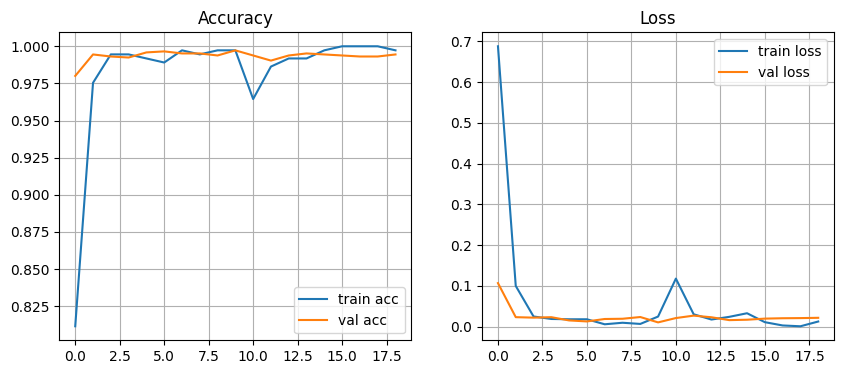

In [12]:
plt.figure(figsize=(10,4))

# accuracy
plt.subplot(1,2,1)
plt.plot(history_stage1.history['accuracy'] + history_stage2.history['accuracy'], label='train acc')
plt.plot(history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.grid()

# loss
plt.subplot(1,2,2)
plt.plot(history_stage1.history['loss'] + history_stage2.history['loss'], label='train loss')
plt.plot(history_stage1.history['val_loss'] + history_stage2.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.grid()

plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step
📊 Classification Report (MobileNetV2 fine-tuned):
              precision    recall  f1-score   support

  Motorbikes       0.99      1.00      1.00       638
   airplanes       1.00      1.00      1.00       640
    car_side       1.00      1.00      1.00        98
       ferry       0.98      0.98      0.98        53
inline_skate       1.00      0.79      0.88        24

    accuracy                           1.00      1453
   macro avg       0.99      0.95      0.97      1453
weighted avg       1.00      1.00      0.99      1453



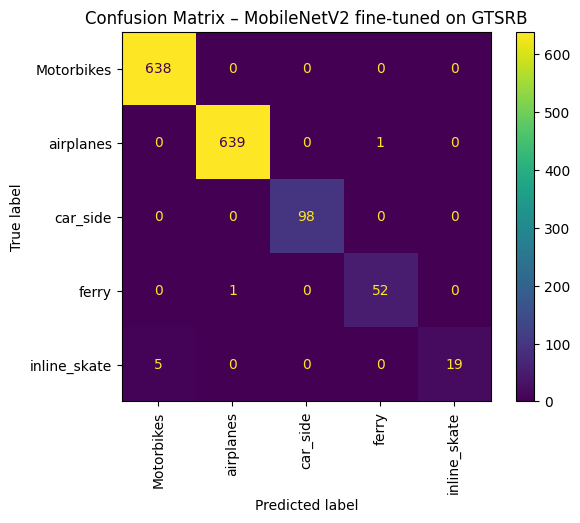

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_generator.reset()
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

print(" Classification Report (MobileNetV2 fine-tuned):")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices.keys())
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix – MobileNetV2 fine-tuned on GTSRB")
plt.show()
